In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [24]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, msubs
from IPython.display import Image
from IPython.core.display import HTML
import scipy.integrate
import math
from numpy.linalg import matrix_power
from scipy.linalg import expm
import os
import time
from itertools import count, takewhile
from more_itertools import numeric_range

%matplotlib notebook

In [25]:
def discretize_ss(A, B, dt):
    A_B = np.block([[A, B],
                [np.zeros((B.shape[1], A.shape[0])), np.zeros((B.shape[1], B.shape[1]))]])

    eAt_d = scipy.linalg.expm(A_B * dt)

    A_d_temp = eAt_d[:A.shape[0], :A.shape[0]]

    B_d_temp = eAt_d[:B.shape[0], A.shape[0]:]

    return (A_d_temp, B_d_temp)

In [26]:
def get_integrated_position_trajectory(initial_pos, vel_desired):
    x_ref_temp = np.zeros((n, N))

    pos_desired = initial_pos
    for i in range(0, N):
        pos_desired += vel_desired * dt
        x_ref_temp[:, i] = np.array([0, 0, 0, 0, pos_desired, 1, 0, 0, 0, 0, vel_desired, 0, -9.81])
        
    return x_ref_temp

In [27]:
def get_joint_torques(f_x, f_y, f_z, theta1, theta2, theta3, theta4, theta5, phi, theta, psi):
    return np.array([[f_x*(0.41*sin(theta2)*sin(psi + theta1)*cos(theta3) + 0.4*sin(theta2)*sin(psi + theta1)*cos(theta3 + theta4) + 0.04*sin(theta2)*sin(psi + theta1)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta3)*cos(psi + theta1) - 0.4*sin(theta3 + theta4)*cos(psi + theta1) - 0.04*sin(theta3 + theta4 + theta5)*cos(psi + theta1))*cos(theta) + f_y*((sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.41*sin(theta1)*sin(theta3) + 0.4*sin(theta1)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta3 + theta4 + theta5) + 0.41*sin(theta2)*cos(theta1)*cos(theta3) + 0.4*sin(theta2)*cos(theta1)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta1)*cos(theta3 + theta4 + theta5)) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.41*sin(theta1)*sin(theta2)*cos(theta3) + 0.4*sin(theta1)*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta3)*cos(theta1) - 0.4*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta3 + theta4 + theta5)*cos(theta1))) + f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.41*sin(theta1)*sin(theta2)*cos(theta3) + 0.4*sin(theta1)*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta3)*cos(theta1) - 0.4*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta3 + theta4 + theta5)*cos(theta1)) - (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.41*sin(theta1)*sin(theta3) + 0.4*sin(theta1)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta3 + theta4 + theta5) + 0.41*sin(theta2)*cos(theta1)*cos(theta3) + 0.4*sin(theta2)*cos(theta1)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta1)*cos(theta3 + theta4 + theta5)))], [f_x*((0.41*sin(theta2)*cos(theta3) + 0.4*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta3 + theta4 + theta5))*sin(theta) + (0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*sin(psi)*sin(theta1)*cos(theta) - (0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*cos(psi)*cos(theta)*cos(theta1)) - f_y*(-(sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*sin(theta1) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*cos(theta1) + (0.41*sin(theta2)*cos(theta3) + 0.4*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta3 + theta4 + theta5))*sin(phi)*cos(theta)) - f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*cos(theta1) + (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*sin(theta1) - (0.41*sin(theta2)*cos(theta3) + 0.4*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta3 + theta4 + theta5))*cos(phi)*cos(theta))], [-f_x*(-0.41*sin(theta)*sin(theta3)*cos(theta2) - 0.4*sin(theta)*sin(theta3 + theta4)*cos(theta2) - 0.04*sin(theta)*sin(theta3 + theta4 + theta5)*cos(theta2) - 0.41*sin(theta2)*sin(theta3)*cos(theta)*cos(psi + theta1) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta)*cos(psi + theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(psi + theta1) + 0.41*sin(psi + theta1)*cos(theta)*cos(theta3) + 0.4*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4) + 0.04*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4 + theta5)) - f_y*((sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.41*sin(theta1)*sin(theta2)*sin(theta3) + 0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.41*cos(theta1)*cos(theta3) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.41*sin(theta1)*cos(theta3) + 0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta2)*sin(theta3)*cos(theta1) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (-0.41*sin(theta3) - 0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*sin(phi)*cos(theta)*cos(theta2)) - f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.41*sin(theta1)*cos(theta3) + 0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta2)*sin(theta3)*cos(theta1) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.41*sin(theta1)*sin(theta2)*sin(theta3) + 0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.41*cos(theta1)*cos(theta3) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (-0.41*sin(theta3) - 0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*cos(phi)*cos(theta)*cos(theta2))], [-f_x*(-0.4*sin(theta)*sin(theta3 + theta4)*cos(theta2) - 0.04*sin(theta)*sin(theta3 + theta4 + theta5)*cos(theta2) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta)*cos(psi + theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(psi + theta1) + 0.4*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4) + 0.04*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4 + theta5)) - f_y*((sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (-0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*sin(phi)*cos(theta)*cos(theta2)) - f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (-0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*cos(phi)*cos(theta)*cos(theta2))], [-f_x*(-0.04*sin(theta)*sin(theta3 + theta4 + theta5)*cos(theta2) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(psi + theta1) + 0.04*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4 + theta5)) - f_y*(-0.04*(-sin(theta1)*cos(theta3 + theta4 + theta5) + sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1))*(sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi)) + 0.04*(sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + cos(theta1)*cos(theta3 + theta4 + theta5)) + 0.04*sin(phi)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(theta2)) - f_z*(-0.04*(sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(-sin(theta1)*cos(theta3 + theta4 + theta5) + sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - 0.04*(sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + cos(theta1)*cos(theta3 + theta4 + theta5)) - 0.04*sin(theta3 + theta4 + theta5)*cos(phi)*cos(theta)*cos(theta2))]])

P_cols: 521
Minimum possible Force in X and Y direction: -280.0
Maximum possible Force in X and Y direction: 280.0
Compiling C Code for solver...
Finished compiling.
Entering main MPC loop...
Final MPC iterations: 600
Steady state error:
 [[ 4.70558123e-03]
 [-1.37388340e-05]
 [-1.58472577e-05]
 [-5.48333810e-08]
 [ 1.81133861e-02]
 [ 4.91664902e-06]
 [-9.31087417e-06]
 [ 7.47859151e-06]
 [ 8.67105530e-06]
 [ 3.00198504e-08]
 [ 4.44407010e-04]
 [ 1.18072971e-07]
 [ 0.00000000e+00]]


<IPython.core.display.Javascript object>


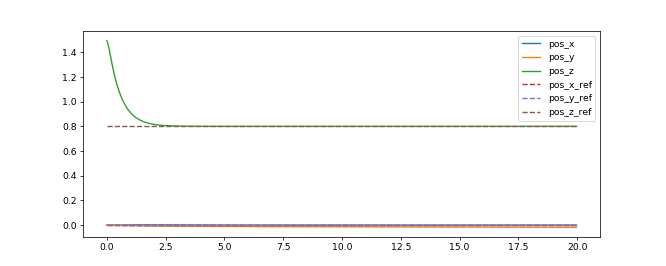

<IPython.core.display.Javascript object>


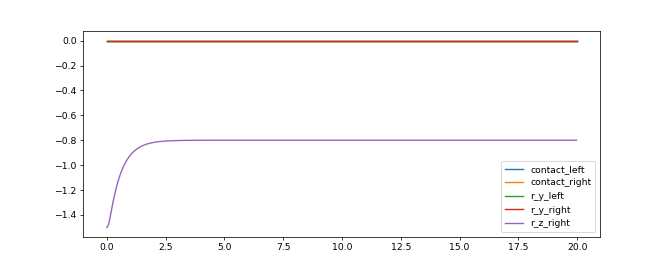

<IPython.core.display.Javascript object>


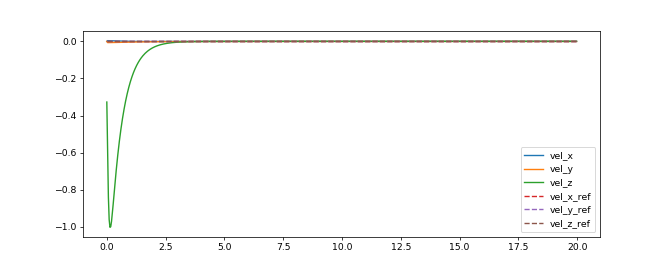

<IPython.core.display.Javascript object>


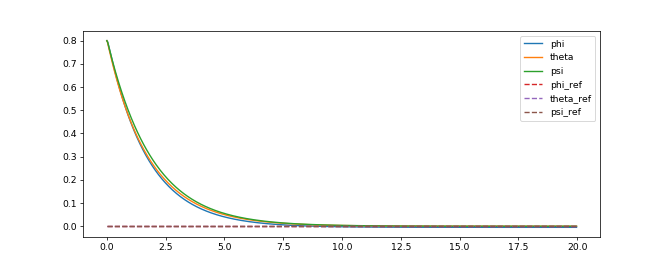

<IPython.core.display.Javascript object>


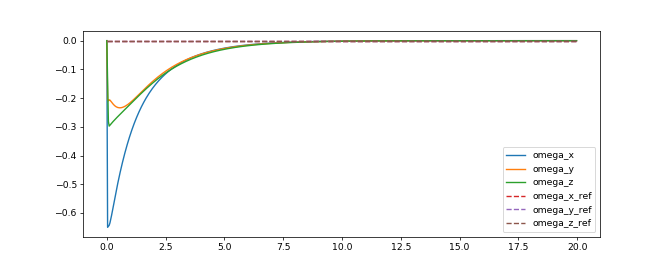

<IPython.core.display.Javascript object>


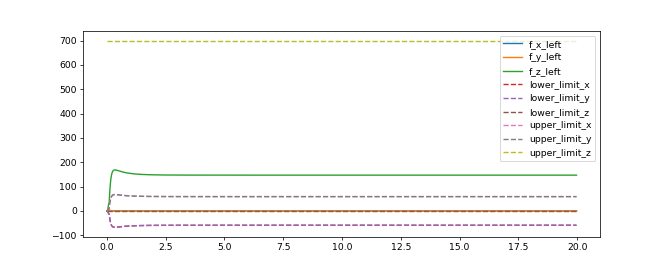

<IPython.core.display.Javascript object>


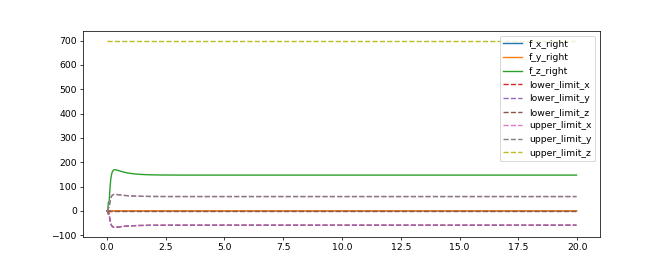

<IPython.core.display.Javascript object>


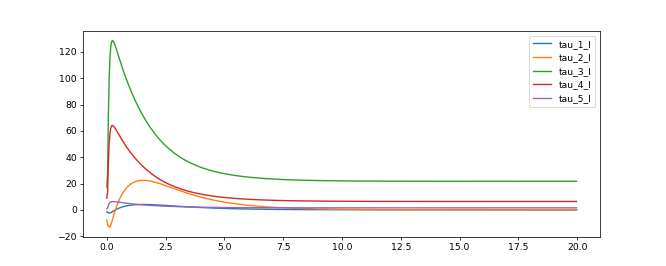

<IPython.core.display.Javascript object>


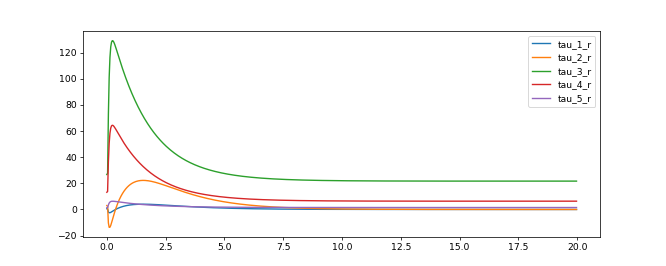

<IPython.core.display.Javascript object>


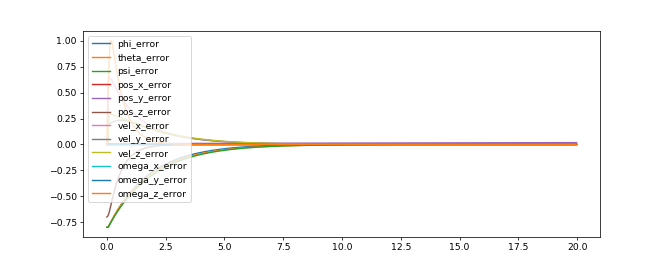

<IPython.core.display.Javascript object>


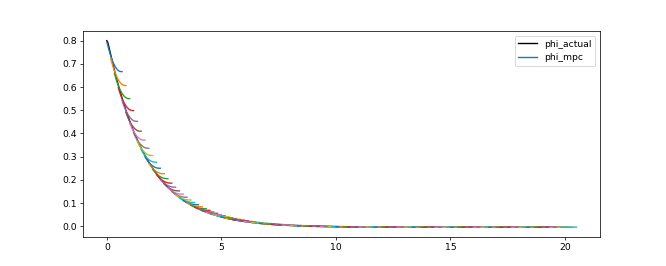

<IPython.core.display.Javascript object>


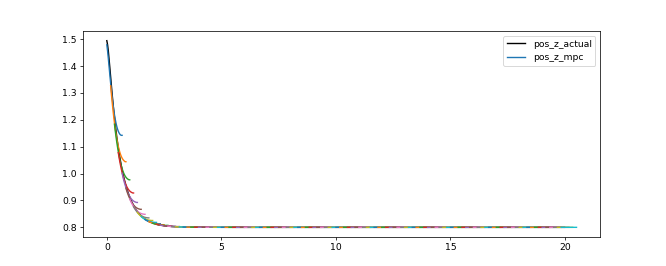

<IPython.core.display.Javascript object>


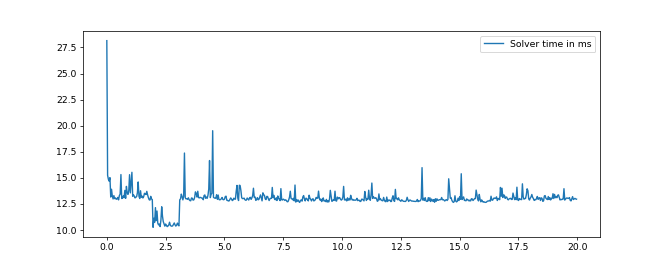

In [32]:
# MPC for full point mass model #######################################################
from casadi import *

dt = 1/30 # [s] (sampling time interval)
N = 20 # Prediction horizon Length

mu = 0.4

f_min_z = 0
f_max_z = 700

f_min_x = f_min_y = -mu * f_max_z
f_max_x = f_max_y = mu * f_max_z

phi = SX.sym('phi') # Orientation Euler Angle 1
theta = SX.sym('theta') # Orientation Euler Angle 2
psi = SX.sym('psi') # Orientation Euler Angle 3

omega_x = SX.sym('omega_x')
omega_y = SX.sym('omega_y')
omega_z = SX.sym('omega_z')

p_x = SX.sym('p_x') # position X
p_y = SX.sym('p_y') # position Y
p_z = SX.sym('p_z') # position Z

v_x = SX.sym('v_x') # velocity X
v_y = SX.sym('v_y') # velocity Y
v_z = SX.sym('v_z') # velocity Z

g_constant = SX.sym('g') # gravity state / constant (is augmented to allow state space form), might be seperated again for readability

states = [phi, theta, psi, p_x, p_y, p_z, omega_x, omega_y, omega_z, v_x, v_y, v_z, g_constant]
n = len(states)

f_x_l = SX.sym('f_x_l') # Force in X on left foot
f_y_l = SX.sym('f_y_l') # Force in Y on left foot
f_z_l = SX.sym('f_z_l') # Force in Z on left foot

f_x_r = SX.sym('f_x_r') # Force in X on right foot
f_y_r = SX.sym('f_y_r') # Force in Y on right foot
f_z_r = SX.sym('f_z_r') # Force in Z on right foot

controls = [f_x_l, f_y_l, f_z_l, f_x_r, f_y_r, f_z_r]
m = len(controls)

U = SX.sym('U', m, N) # Control action matrix (that will be determined by the NLP solver)
X = SX.sym('X', n, N + 1) # State Matrix (that will also be determined by the NLP solver due to the chosen multiple-shooting method). The + 1 is for x0
P_rows = n
P_cols = 1 + N + n * N + m * N + N * m # last N* m for D matrix at each time step (used for contact constraint, passing D for every timestep allows to inform MPC about future contacts), REDUCE DIMENSIONALITY BY STATING CONTACT AS 1 OR 0!!!
print("P_cols:", P_cols)
P = SX.sym('P', P_rows, P_cols) # Parameter Matrix

objective_function = 0 # expression for the objective function

# lbx = lower bounds on optimization variable(s)
# ubx = upper bounds on optimization variable(s)
# lbg = lower bounds on constraints vector (should also be a vector), for equality constraints, just set lbg=ubg=k, where k is the constraint value
# ubg = upper bounds on constraints vector (should also be a vector)

lbx = []
ubx = []
lbg = []
ubg = []

g = [] # Constraint vector (both equality and inequality)

g += [X[:, 0] - P[:, 0]] # equality constraint x0 (chosen by solver) - x0 (input as parameter by user) = 0

lbg += [0] * n # n zeroes for equality constraints. These exist to ensure solver and actual initial state are the same.
ubg += [0] * n # n zeroes for equality constraints. These exist to ensure solver and actual initial state are the same.

#Proven to be reasonbly stable:
Q = np.diag([1000,1000,1000,5000,5000,5000,1000,1000,1000,1000,1000,1000,0])
R = np.diag([0.008, 0.008, 0.008, 0.008, 0.008, 0.008])

#Q = np.diag([10,100,10,10,10,100,50,2000,50,100,100,100,0])
#R = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

r_y_left = r_y_right = 0
r_x_left = -0.15
r_x_right = 0.15
r_z_left = r_z_right = -1.5

t = 0

# state is phi, theta, psi, p_x, p_y, p_z, omega_x, omega_y, omega_z, v_x, v_y, v_z, gravity constant

x_t = [0.8, 0.8, 0.8, 0, 0, 1.5, 0, 0, 0, 0, 0, 0, -9.81]
#x_t = [0.0, -0.0, 0.0, 0.0, 0.0, 0.840062, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125047, -9.81]

state_history = []
reference_state_history = []
optimal_state_history = []
optimal_control_history = []
control_history = [np.zeros((m, 1)), np.zeros((m, 1))]
r_left_history = []
r_right_history = []
t_history = []

solver_time_history = []

state_error_history = []
contact_matrix_history = []

discretization_r_y_history = []

state_full_control_applied_history = []
first_control_history = []

torque_history = []

orientation_predicted_history = []
vel_predicted_history = []

contact_history = []

m_value = 30 # kg

P_param = np.zeros((P_rows, P_cols))

#P_param[m:m+m, 1 + N + n*N + m*N + 1] = np.array([0, 0, 289.432, 0, 0, 289.432]).reshape(m)

#P_param[:, 0] = np.array(x_t).copy()

swing_left = True
swing_right = False

for i in range(N):
    state = X[:, i] # extract state at current time step
    control = U[:, i] # extract control input at current time step
    
    # Add the symbolic cost for each time step to the objective function based on different contact sets
    u_ref = P[m:m+m, 1 + N + n*N + m*N + (i*m)]
    objective_function = objective_function + (state - P[:, i+1]).T @ Q @ (state - P[:, i+1]) + (control - u_ref).T @ R @ (control - u_ref)
    # This is the equality constraint required for multiple shooting, so that the solver respects the system dynamics
    next_state = X[:, i+1]
    A_d_t = P[:, 1+N+(i*n):1+N+(i*n)+n]
    B_d_t = P[:, 1 + N + n*N +(i*m):1 + N + n*N + (i*m)+m]
    
    next_state_simulation = A_d_t @ state + B_d_t @ control
        
    g += [next_state - next_state_simulation]
    
    lbg += [0] * n # n zeroes for equality constraints enforcing system dynamcis on every state
    ubg += [0] * n # n zeroes for equality constraints enforcing system dynamcis on every state

for i in range(N): # Contact constraints D * u = 0
    g += [P[:m, 1 + N + n*N + m*N + (i*m):1 + N + n*N + m*N + (i*m) + m] @ U[:, i]]
    lbg += [0] * m
    ubg += [0] * m

for i in range(N): # Friction cone constraints. Seperate loops to have a nice structure in constraints
    f_x_left = U[0, i]
    f_y_left = U[1, i]
    f_z_left = U[2, i]

    f_x_right = U[3, i]
    f_y_right = U[4, i]
    f_z_right = U[5, i]

    # -mu * f_z < f_x
    g += [-mu * f_z_left - f_x_left]
    lbg += [-inf]
    ubg += [0]

    # f_x < mu * f_z
    g += [f_x_left - mu * f_z_left]
    lbg += [-inf]
    ubg += [0]

    # -mu * f_z < f_y
    g += [-mu * f_z_left - f_y_left]
    lbg += [-inf]
    ubg += [0]

    # f_y < mu * f_z
    g += [f_y_left - mu * f_z_left]
    lbg += [-inf]
    ubg += [0]

    # -mu * f_z < f_x
    g += [-mu * f_z_right - f_x_right]
    lbg += [-inf]
    ubg += [0]

    # f_x < mu * f_z
    g += [f_x_right - mu * f_z_right]
    lbg += [-inf]
    ubg += [0]

    # -mu * f_z < f_y
    g += [-mu * f_z_right - f_y_right]
    lbg += [-inf]
    ubg += [0]

    # f_y < mu * f_z
    g += [f_y_right - mu * f_z_right]
    lbg += [-inf]
    ubg += [0]  
            
optimization_variables = [X.reshape((n * (N+1), 1)), U.reshape((m * N, 1))]
nlp = {'x':vertcat(*optimization_variables), 'f':objective_function, 'g':vertcat(*g), 'p':P}

opts = {}
opts["print_time"] = 0
opts["expand"] = False
opts['ipopt'] = {"max_iter":40, "print_level":0, "acceptable_tol":1e-7, "acceptable_obj_change_tol":1e-5}

solver = nlpsol('solver', 'ipopt', nlp, opts);

# Initialization values for solver
U_t = np.zeros((m * N, 1))
X_t = np.matlib.repmat(np.array(x_t).reshape(n,1), N+1, 1)#.reshape(n*(N+1), 1) # np.tile(np.array(x_t).reshape(n, 1), N+1)

simulation_time = 20 # [s]
    
iterations = 0

I_body = np.array([[0.1536, 0., 0.],
                    [0., 0.62288, 0.],
                    [0., 0., 0.6843]]) # Inertia in the body frame (meaning around CoM of torso).

Ixx = I_body[0, 0]
Ixy = I_body[0, 1]
Ixz = I_body[0, 2]

Iyx = I_body[1, 0]
Iyy = I_body[1, 1]
Iyz = I_body[1, 2]

Izx = I_body[2, 0]
Izy = I_body[2, 1]
Izz = I_body[2, 2]

for i in range(n * (N+1)):
    lbx += [-inf]
    ubx += [inf]
    
for i in range(N): # Should be possible to reduce the number of constraints if needed since the x and y forces are already limited by the friction constraint
    lbx += [-inf, -inf, f_min_z, -inf, -inf, f_min_z]
    ubx += [inf, inf, f_max_z, inf, inf, f_max_z]
            
print("Minimum possible Force in X and Y direction:", -mu * f_max_z)
print("Maximum possible Force in X and Y direction:", mu * f_max_z)

use_C_code = True

solver.generate_dependencies('nlp.c')

if use_C_code:
    print("Compiling C Code for solver...")

    solver.generate_dependencies('nlp.c')
    os.system("gcc -O2 -fPIC -shared nlp.c -o nlp.so")
    solver = nlpsol("solver", "ipopt", "nlp.so", opts)
    print("Finished compiling.")

foot_behind_left = not swing_left # This is because it will be inverted on the first contact switch
foot_behind_right = not swing_right

pos_y_desired = 0
vel_y_desired = 0

psi_desired = 0
omega_z_desired = 0

step_length = 0

contact_swap_interval = 15

x_t = np.array(x_t).reshape(n,1)

iterations_left_until_contact_swap = contact_swap_interval

print("Entering main MPC loop...")

while t < simulation_time:
    
    iterations_left_until_contact_swap -= 1
    
    if iterations % contact_swap_interval == 0:
        swing_left = not swing_left
        swing_right = not swing_right
        iterations_left_until_contact_swap = contact_swap_interval
    
    
    swing_left_temp = swing_left
    swing_right_temp = swing_right
    
    for k in range(N):
        if (iterations+k) % contact_swap_interval == 0 and k is not 0:
            swing_left_temp = not swing_left_temp
            swing_right_temp = not swing_right_temp
            
        D_current_temp = np.array([[int(swing_left_temp == True), 0, 0, 0, 0, 0],
                              [0, int(swing_left_temp == True), 0, 0, 0, 0],
                              [0, 0, int(swing_left_temp == True), 0, 0, 0],
                              [0, 0, 0, int(swing_right_temp == True), 0, 0],
                              [0, 0, 0, 0, int(swing_right_temp == True), 0],
                              [0, 0, 0, 0, 0, int(swing_right_temp == True)]]) # Swing = no contact (and thus 1 any force == 0 must mean force is 0)    
        
        #P_param[:m, 1+N+n*N+m*N+(k*m):1+N+n*N+m*N+(k*m)+m] = D_current_temp.copy()
        
        if P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][0, 0] == 1 and P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][3, 3] == 1: # No feet in contact
            P_param[m:m+m, 1 + N + n*N + m*N + (k*m)] = np.array([0, 0, 0, 0, 0, 0]).copy()
            #print("No feet in contact")
        elif P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][0, 0] == 1 and P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][3, 3] == 0: # Right foot in contact
            P_param[m:m+m, 1 + N + n*N + m*N + (k*m)] = np.array([0, 0, 0, 0, 0, m_value * 9.81]).copy()
            #print("Right foot in contact")
        elif  P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][0, 0] == 0 and P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][3, 3] == 1: # Left foot in contact
            P_param[m:m+m, 1 + N + n*N + m*N + (k*m)] = np.array([0, 0, m_value * 9.81, 0, 0, 0]).copy()
            #print("Left foot in contact")
        if  P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][0, 0] == 0 and P_param[:m, 1 + N + n*N + m*N + k*m: 1 + N + n*N + m*N + k*m + m][3, 3] == 0: # Both feet in contact
            P_param[m:m+m, 1 + N + n*N + m*N + (k*m)] = np.array([0, 0, (m_value * 9.81) / 2, 0, 0, (m_value * 9.81) / 2]).copy()
            #print("Both feet in contact")
    
    
    contact_history.append([P_param[:m, 1 + N + n*N + m*N:1 + N + n*N + m*N+m][0, 0].copy(), P_param[:m, 1 + N + n*N + m*N:1 + N + n*N + m*N+m][3, 3]].copy())
    
    if foot_behind_left:
        r_y_left = -step_length
    else:
        r_y_left = step_length
            
    if foot_behind_right:
        r_y_right = -step_length
    else:
        r_y_right = step_length
    
    if iterations % (contact_swap_interval * 2) == 0:
        foot_behind_left = not foot_behind_left
        foot_behind_right = not foot_behind_right
    
    r_z_left = -x_t[5]
    r_z_right = -x_t[5]
    
    x_ref = np.zeros((n, N))
    
    pos_y_temp = pos_y_desired
    psi_temp = psi_desired
    
    for i in range(N):
        pos_y_temp += vel_y_desired * dt
        psi_temp += omega_z_desired * dt
        x_ref[:, i] = np.array([0, 0, psi_temp, 0, pos_y_temp, 0.8, 0, 0, omega_z_desired, 0, vel_y_desired, 0, -9.81]).reshape(n)
        
    pos_y_desired += vel_y_desired * dt
    psi_desired += omega_z_desired * dt

    P_param[:, 1:1 + N] = x_ref.copy()

    reference_state_history.append(x_ref[:, 0].reshape(n,1).copy()) # or -1
    
    state_error_history.append(x_ref[:, 0].copy().reshape(n,1) - x_t.copy())
    
    foot_behind_left_temp = foot_behind_left
    foot_behind_right_temp = foot_behind_right
    
    r_y_left_prev = r_y_left
    r_y_right_prev = r_y_right
    
    for i in range(N):
        if i < N-1:
            phi_t = X_t[n*(i+1)+0]
            theta_t = X_t[n*(i+1)+1]
            psi_t = X_t[n*(i+1)+2]
            
            vel_x_t = X_t[n*(i+1)+9]
            vel_y_t = X_t[n*(i+1)+10]
            vel_z_t = X_t[n*(i+1)+11]
            
            pos_x_t = X_t[n*(i+1)+3]
            pos_y_t = X_t[n*(i+1)+4]
            pos_y_t_next = X_t[n*(i+2)+4]
            pos_z_t = X_t[n*(i+1)+5]
        else:
            phi_t = X_t[n*(N-1)]
            theta_t = X_t[n*(N-1)+1]
            psi_t = X_t[n*(N-1)+2]
            
            vel_x_t = X_t[n*(N-1)+9]
            vel_y_t = X_t[n*(N-1)+10]
            vel_z_t = X_t[n*(N-1)+11]
            
            pos_x_t = X_t[n*(N-1)+3]
            pos_y_t = X_t[n*(N-1)+4]
            pos_y_t_next = X_t[n*N + 4]
            pos_z_t = X_t[n*(N-1)+5]
            
        if i == 0:
            phi_t = x_t[0]
            theta_t = x_t[1]
            psi_t = x_t[2]

            vel_x_t = x_t[9]
            vel_y_t = x_t[10]
            vel_z_t = x_t[11]

            pos_x_t = x_t[3]
            pos_y_t = x_t[4]
            pos_z_t = x_t[5]
            
        if foot_behind_left_temp:
            r_y_left = -step_length
        else:
            r_y_left = step_length
            
        if foot_behind_right_temp:
            r_y_right = -step_length
        else:
            r_y_right = step_length
        
        if (iterations+i) % (contact_swap_interval * 2) == 0 and i is not 0:
            foot_behind_left_temp = not foot_behind_left_temp
            foot_behind_right_temp = not foot_behind_right_temp
        
        r_z_left = -pos_z_t
        r_z_right = -pos_z_t
        
        if iterations == 20:
            discretization_r_y_history.append([r_y_left, r_y_right])
        
        r_y_left -= (pos_y_t_next - pos_y_t)
        r_y_right -= (pos_y_t_next - pos_y_t)
        
        orientation_predicted_history.append([phi_t, theta_t, psi_t])
        vel_predicted_history.append([vel_x_t, vel_y_t, vel_z_t])

        I_world = np.array([[(Ixx*cos(psi_t) + Iyx*sin(psi_t))*cos(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*sin(psi_t), -(Ixx*cos(psi_t) + Iyx*sin(psi_t))*sin(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*cos(psi_t), Ixz*cos(psi_t) + Iyz*sin(psi_t)], [(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*cos(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*sin(psi_t), -(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*sin(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*cos(psi_t), -Ixz*sin(psi_t) + Iyz*cos(psi_t)], [Ixy*sin(psi_t) + Izx*cos(psi_t), Ixy*cos(psi_t) - Izx*sin(psi_t), Izz]])
        
        # Skew symmetric versions for the 3x1 foot position vector resembling the matrix version of the cross product of two vectors. This is needed for the matrix form.
        r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                          [r_z_left, 0, -r_x_left],
                                          [-r_y_left, r_x_left, 0]])

        r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                           [r_z_right, 0, -r_x_right],
                                           [-r_y_right, r_x_right, 0]])

        A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(psi_t)*math.cos(theta_t), -math.sin(psi_t)*math.cos(theta_t), math.sin(theta_t), 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, math.sin(phi_t)*math.sin(theta_t)*math.cos(psi_t) + math.sin(psi_t)*math.cos(phi_t), -math.sin(phi_t)*math.sin(psi_t)*math.sin(theta_t) + math.cos(phi_t)*math.cos(psi_t), -math.sin(phi_t)*math.cos(theta_t), 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, math.sin(phi_t)*math.sin(psi_t) - math.sin(theta_t)*math.cos(phi_t)*math.cos(psi_t), math.sin(phi_t)*math.cos(psi_t) + math.sin(psi_t)*math.sin(theta_t)*math.cos(phi_t), math.cos(phi_t)*math.cos(theta_t), 0, 0, 0, 0],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

        B_c = np.block([[0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0],
                        [np.linalg.inv(I_world) @ r_left_skew_symmetric, np.linalg.inv(I_world) @ r_right_skew_symmetric],
                        [1/m_value, 0, 0, 1/m_value, 0, 0],
                        [0, 1/m_value, 0, 0, 1/m_value, 0],
                        [0, 0, 1/m_value, 0, 0, 1/m_value],
                        [0, 0, 0, 0, 0, 0]])
        
        A_d, B_d = discretize_ss(A_c, B_c, dt)
        
        P_param[:, 1 + N + (i*n):1 + N + (i*n)+n] = A_d.copy()
        P_param[:, 1 + N + n * N + (i*m):1 + N + n * N + (i*m)+m] = B_d.copy()
    
    x0_solver = vertcat(*[X_t, U_t])
    
    #Step the model one timestep to account for delay caused by solver time
    phi_t = x_t[0]
    theta_t = x_t[1]
    psi_t = x_t[2]
    r_z_left = -x_t[5]
    r_z_right = -x_t[5]
    
    I_world = np.array([[(Ixx*cos(psi_t) + Iyx*sin(psi_t))*cos(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*sin(psi_t), -(Ixx*cos(psi_t) + Iyx*sin(psi_t))*sin(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*cos(psi_t), Ixz*cos(psi_t) + Iyz*sin(psi_t)], [(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*cos(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*sin(psi_t), -(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*sin(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*cos(psi_t), -Ixz*sin(psi_t) + Iyz*cos(psi_t)], [Ixy*sin(psi_t) + Izx*cos(psi_t), Ixy*cos(psi_t) - Izx*sin(psi_t), Izz]])
    
    r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                      [r_z_left, 0, -r_x_left],
                                      [-r_y_left, r_x_left, 0]])
    
    r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                       [r_z_right, 0, -r_x_right],
                                       [-r_y_right, r_x_right, 0]])
    
    A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(psi_t)*math.cos(theta_t), -math.sin(psi_t)*math.cos(theta_t), math.sin(theta_t), 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, math.sin(phi_t)*math.sin(theta_t)*math.cos(psi_t) + math.sin(psi_t)*math.cos(phi_t), -math.sin(phi_t)*math.sin(psi_t)*math.sin(theta_t) + math.cos(phi_t)*math.cos(psi_t), -math.sin(phi_t)*math.cos(theta_t), 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, math.sin(phi_t)*math.sin(psi_t) - math.sin(theta_t)*math.cos(phi_t)*math.cos(psi_t), math.sin(phi_t)*math.cos(psi_t) + math.sin(psi_t)*math.sin(theta_t)*math.cos(phi_t), math.cos(phi_t)*math.cos(theta_t), 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    
    B_c = np.block([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [np.linalg.inv(I_world) @ r_left_skew_symmetric, np.linalg.inv(I_world) @ r_right_skew_symmetric],
                    [1/m_value, 0, 0, 1/m_value, 0, 0],
                    [0, 1/m_value, 0, 0, 1/m_value, 0],
                    [0, 0, 1/m_value, 0, 0, 1/m_value],
                    [0, 0, 0, 0, 0, 0]])
    
    A_d, B_d = discretize_ss(A_c, B_c, dt)
    
    x_t_temp = A_d @ np.array(x_t).reshape(n,1) + B_d @ control_history[-1]
    P_param[:, 0] = x_t_temp.reshape(n).copy()
    
    start_time = time.time()
    sol = solver(x0=x0_solver, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=DM(P_param))
    end_time = time.time()
    solver_time_history.append((end_time - start_time) * 1000)
    
    t_history.append(t)
    
    u_t = sol['x'][n * (N+1) :n * (N+1) + m]
    control_history.append(np.array(u_t).reshape(m,1).copy())
    
    phi_t = x_t[0]
    theta_t = x_t[1]
    psi_t = x_t[2]
    r_z_left = -x_t[5]
    r_z_right = -x_t[5]
    
    I_world = np.array([[(Ixx*cos(psi_t) + Iyx*sin(psi_t))*cos(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*sin(psi_t), -(Ixx*cos(psi_t) + Iyx*sin(psi_t))*sin(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*cos(psi_t), Ixz*cos(psi_t) + Iyz*sin(psi_t)], [(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*cos(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*sin(psi_t), -(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*sin(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*cos(psi_t), -Ixz*sin(psi_t) + Iyz*cos(psi_t)], [Ixy*sin(psi_t) + Izx*cos(psi_t), Ixy*cos(psi_t) - Izx*sin(psi_t), Izz]])
    
    r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                      [r_z_left, 0, -r_x_left],
                                      [-r_y_left, r_x_left, 0]])
    
    r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                       [r_z_right, 0, -r_x_right],
                                       [-r_y_right, r_x_right, 0]])
    
    A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(psi_t)*math.cos(theta_t), -math.sin(psi_t)*math.cos(theta_t), math.sin(theta_t), 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, math.sin(phi_t)*math.sin(theta_t)*math.cos(psi_t) + math.sin(psi_t)*math.cos(phi_t), -math.sin(phi_t)*math.sin(psi_t)*math.sin(theta_t) + math.cos(phi_t)*math.cos(psi_t), -math.sin(phi_t)*math.cos(theta_t), 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, math.sin(phi_t)*math.sin(psi_t) - math.sin(theta_t)*math.cos(phi_t)*math.cos(psi_t), math.sin(phi_t)*math.cos(psi_t) + math.sin(psi_t)*math.sin(theta_t)*math.cos(phi_t), math.cos(phi_t)*math.cos(theta_t), 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    
    B_c = np.block([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [np.linalg.inv(I_world) @ r_left_skew_symmetric, np.linalg.inv(I_world) @ r_right_skew_symmetric],
                    [1/m_value, 0, 0, 1/m_value, 0, 0],
                    [0, 1/m_value, 0, 0, 1/m_value, 0],
                    [0, 0, 1/m_value, 0, 0, 1/m_value],
                    [0, 0, 0, 0, 0, 0]])
    
    A_d, B_d = discretize_ss(A_c, B_c, dt)
    
    x_t = A_d @ np.array(x_t).reshape(n,1) + B_d @ control_history[-2]
    
    tau_l = get_joint_torques(u_t[0], u_t[1], u_t[2], math.radians(0), math.radians(0), math.radians(15), math.radians(-10), math.radians(10), x_t[0], x_t[1], x_t[2])
    tau_r = get_joint_torques(u_t[3], u_t[4], u_t[5], math.radians(0), math.radians(0), math.radians(15), math.radians(-10), math.radians(10), x_t[0], x_t[1], x_t[2])
    torque_history.append([tau_l.copy(), tau_r.copy()])
        
    X_t[:-n] = sol['x'][n:n * (N+1)]
    X_t[-n:] = sol['x'][-n - m * N: n * (N+1)]
    
    U_t[:-m] = sol['x'][m + n * (N+1):]
    U_t[-m:] = sol['x'][-m:]
    
    optimal_state_history.append(X_t.copy())
    optimal_control_history.append(U_t.copy())
    
    first_control_history.append(sol['x'][n*(N+1):n*(N+1)+m])
    
    state_history.append(x_t)
    r_left_history.append([r_x_left, r_y_left, r_z_left])
    r_right_history.append([r_x_right, r_y_right, r_z_right])

    t += dt
    iterations += 1
    
print("Final MPC iterations:", iterations)
print("Steady state error:\n", (x_ref[: ,0].reshape(n,1) - x_t))


plt.rcParams['figure.figsize'] = [10, 4] #inches
plt.rcParams.update({'figure.max_open_warning': 0})

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[3] for x in state_history],label="pos_x")
ax.plot(t_history, [x[4] for x in state_history],label="pos_y")
ax.plot(t_history, [x[5] for x in state_history],label="pos_z")

t_history_interval = int(len(t_history) / int(len(t_history) / N)) # I know this is ugly, but who cares :)

ax.plot(t_history, [x[3][0] for x in reference_state_history], label="pos_x_ref", linestyle='--')
ax.plot(t_history, [x[4][0] for x in reference_state_history], label="pos_y_ref", linestyle='--')
ax.plot(t_history, [x[5][0] for x in reference_state_history], label="pos_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in contact_history], label="contact_left")
ax.plot(t_history, [x[1] for x in contact_history], label="contact_right")

ax.plot(t_history, [x[1] for x in r_left_history], label="r_y_left")

ax.plot(t_history, [x[1] for x in r_right_history], label="r_y_right")
ax.plot(t_history, [x[2] for x in r_right_history], label="r_z_right")
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[9] for x in state_history],label="vel_x")
ax.plot(t_history, [x[10] for x in state_history],label="vel_y")
ax.plot(t_history, [x[11] for x in state_history],label="vel_z")

ax.plot(t_history, [x[9][0] for x in reference_state_history], label="vel_x_ref", linestyle='--')
ax.plot(t_history, [x[10][0] for x in reference_state_history], label="vel_y_ref", linestyle='--')
ax.plot(t_history, [x[11][0] for x in reference_state_history], label="vel_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in state_history],label="phi")
ax.plot(t_history, [x[1] for x in state_history],label="theta")
ax.plot(t_history, [x[2] for x in state_history],label="psi")

ax.plot(t_history, [x[0][0] for x in reference_state_history], label="phi_ref", linestyle='--')
ax.plot(t_history, [x[1][0] for x in reference_state_history], label="theta_ref", linestyle='--')
ax.plot(t_history, [x[2][0] for x in reference_state_history], label="psi_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[6] for x in state_history],label="omega_x")
ax.plot(t_history, [x[7] for x in state_history],label="omega_y")
ax.plot(t_history, [x[8] for x in state_history],label="omega_z")

ax.plot(t_history, [x[6][0] for x in reference_state_history], label="omega_x_ref", linestyle='--')
ax.plot(t_history, [x[7][0] for x in reference_state_history], label="omega_y_ref", linestyle='--')
ax.plot(t_history, [x[8][0] for x in reference_state_history], label="omega_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in control_history[:-2]], label="f_x_left")
ax.plot(t_history, [x[1] for x in control_history[:-2]], label="f_y_left")
ax.plot(t_history, [x[2] for x in control_history[:-2]], label="f_z_left")

# no minus needed because f_min is already negative, maybe change that.
ax.plot(t_history, [-mu * f[2] for f in control_history[:-2]], label="lower_limit_x", linestyle='--')
ax.plot(t_history, [-mu * f[2] for f in control_history[:-2]], label="lower_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_min_z, label="lower_limit_z", linestyle='--')

ax.plot(t_history, [mu * f[2] for f in control_history[:-2]], label="upper_limit_x", linestyle='--')
ax.plot(t_history, [mu * f[2] for f in control_history[:-2]], label="upper_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_max_z, label="upper_limit_z", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[3] for x in control_history[:-2]], label="f_x_right")
ax.plot(t_history, [x[4] for x in control_history[:-2]], label="f_y_right")
ax.plot(t_history, [x[5] for x in control_history[:-2]], label="f_z_right")

# no minus needed because f_min is already negative, maybe change that.

ax.plot(t_history, [-mu * f[5] for f in control_history[:-2]], label="lower_limit_x", linestyle='--')
ax.plot(t_history, [-mu * f[5] for f in control_history[:-2]], label="lower_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_min_z, label="lower_limit_z", linestyle='--')

ax.plot(t_history, [mu * f[5] for f in control_history[:-2]], label="upper_limit_x", linestyle='--')
ax.plot(t_history, [mu * f[5] for f in control_history[:-2]], label="upper_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_max_z, label="upper_limit_z", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0][0] for x in torque_history], label="tau_1_l")
ax.plot(t_history, [x[0][1] for x in torque_history], label="tau_2_l")
ax.plot(t_history, [x[0][2] for x in torque_history], label="tau_3_l")
ax.plot(t_history, [x[0][3] for x in torque_history], label="tau_4_l")
ax.plot(t_history, [x[0][4] for x in torque_history], label="tau_5_l")
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[1][0] for x in torque_history], label="tau_1_r")
ax.plot(t_history, [x[1][1] for x in torque_history], label="tau_2_r")
ax.plot(t_history, [x[1][2] for x in torque_history], label="tau_3_r")
ax.plot(t_history, [x[1][3] for x in torque_history], label="tau_4_r")
ax.plot(t_history, [x[1][4] for x in torque_history], label="tau_5_r")
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in state_error_history], label="phi_error")
ax.plot(t_history, [x[1] for x in state_error_history], label="theta_error")
ax.plot(t_history, [x[2] for x in state_error_history], label="psi_error")
ax.plot(t_history, [x[3] for x in state_error_history], label="pos_x_error")
ax.plot(t_history, [x[4] for x in state_error_history], label="pos_y_error")
ax.plot(t_history, [x[5] for x in state_error_history], label="pos_z_error")
ax.plot(t_history, [x[6] for x in state_error_history], label="vel_x_error")
ax.plot(t_history, [x[7] for x in state_error_history], label="vel_y_error")
ax.plot(t_history, [x[8] for x in state_error_history], label="vel_z_error")
ax.plot(t_history, [x[9] for x in state_error_history], label="omega_x_error")
ax.plot(t_history, [x[10] for x in state_error_history], label="omega_y_error")
ax.plot(t_history, [x[11] for x in state_error_history], label="omega_z_error")
plt.legend()

plot_optimal_state_history = True

plot_interval = 5

if plot_optimal_state_history:
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, [x[0] for x in state_history], 'k', label="phi_actual")

    for y in range(0, len(optimal_state_history), plot_interval):
        ax.plot(tuple(numeric_range(y*dt, y*dt+(N+1)*dt, dt)), optimal_state_history[y][0::n], label="phi_mpc")
        if y == 0:
            plt.legend()
            
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, [x[5] for x in state_history], 'k', label="pos_z_actual")

    for y in range(0, len(optimal_state_history), plot_interval):
        ax.plot(tuple(numeric_range(y*dt, y*dt+(N+1)*dt, dt)), optimal_state_history[y][5::n], label="pos_z_mpc")
        if y == 0:
            plt.legend()
            
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, solver_time_history, label="Solver time in ms")
    plt.legend()
    
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    #ax.plot(t_history, [x[2] for x in control_history], 'k', label="u_t")
    #ax.plot(t_history, [first_control[2] for first_control in first_control_history], label="u_mpc")
    #plt.legend()

    #for y in range(0, len(optimal_control_history), plot_interval):
        #ax.plot(tuple(numeric_range(y*dt, y*dt+N*dt, dt)), optimal_control_history[y][0::m], label="u_t_1")
        #ax.plot(tuple(numeric_range(y*dt, y*dt+N*dt, dt)), optimal_control_history[y][1::m], label="u_t_2")
        #ax.plot(tuple(numeric_range(y*dt, y*dt+N*dt, dt)), optimal_control_history[y][2::m],'r', label="u_t_3")
        #ax.plot(tuple(nucmeric_range(y*dt, y*dt+N*dt, dt)), optimal_control_history[y][3::m], label="u_t_4")
        #ax.plot(tuple(numeric_range(y*dt, y*dt+N*dt, dt)), optimal_control_history[y][4::m], label="u_t_5")
        #ax.plot(tuple(numeric_range(y*dt, y*dt+N*dt, dt)), optimal_control_history[y][5::m], label="u_t_6")
        
        #if y == 0:
            #plt.legend()

In [14]:
from casadi import *
import numpy as np

solver = nlpsol("solver", "ipopt", "nlp.so")

opts = {}
opts["print_time"] = 1
opts["expand"] = False
opts['ipopt'] = {"max_iter":40, "print_level":3, "acceptable_tol":1e-7, "acceptable_obj_change_tol":1e-5}

solver = nlpsol("solver", "ipopt", "nlp.so", opts)

lbg = []
ubg = []
lbx = []
ubx = []

n = 13
m = 6
N = 20

dt = 1/30

f_min_z = 0
f_max_z = 1000

# Initial state constraints
lbg += [0] * n
ubg += [0] * n

# Dynamics constraints
for i in range(N):
    lbg += [0] * n
    ubg += [0] * n

# Contact constraints
for i in range(N):
    lbg += [0] * m
    ubg += [0] * m
    
for i in range(N):
        lbg += [-inf] * 8
        ubg += [0] * 8

for i in range(n*(N+1)):
    lbx += [-inf]
    ubx += [inf]

for i in range(N):
    lbx += [-inf, -inf, f_min_z, -inf, -inf, f_min_z]
    ubx += [inf, inf, f_max_z, inf, inf, f_max_z]

x_t = [0.2, 0, 0, 0, 0, 1.5, 0, 0, 0, 0, 0, 0, -9.81]

x_ref = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -9.81]
x_ref = np.tile(np.array(x_ref).reshape(n, 1), N)

U_t = np.zeros((m, N))
X_t = np.zeros((n, N+1))
#X_t = np.tile(np.array(x_t).reshape(n, 1), N+1)

X_t = X_t.reshape((n * (N+1), 1))
U_t = U_t.reshape((m * N, 1))

P_rows = n
P_cols = 1 + N + n * N + m * N + N * m 

P_param = np.zeros((P_rows, P_cols))
P_param[:, 0] = np.array(x_t).reshape(n)
P_param[:, 1:1 + N] = x_ref

swing_left = False
swing_right = False

D = np.array([[int(swing_left == True), 0, 0, 0, 0, 0],
            [0, int(swing_left == True), 0, 0, 0, 0],
            [0, 0, int(swing_left == True), 0, 0, 0],
            [0, 0, 0, int(swing_right == True), 0, 0],
            [0, 0, 0, 0, int(swing_right == True), 0],
            [0, 0, 0, 0, 0, int(swing_right == True)]]) #Swing = no contact (and thus 1 any force == 0 must mean force is 0)

P_param[:m, 1 + N + n*N + m*N:] = np.tile(D, N).copy()

psi_t = 0
theta_t = 0
psi_t = 0

r_x_left = -0.15
r_y_left = 0
r_z_left = -1

r_x_right = 0.15
r_y_right = 0
r_z_right = -1

m_value = 30

I_body = np.array([[0.1536, 0., 0.],
                    [0., 0.62288, 0.],
                    [0., 0., 0.6843]]) # Inertia in the body frame (meaning around CoM of torso).

Ixx = I_body[0, 0]
Ixy = I_body[0, 1]
Ixz = I_body[0, 2]

Iyx = I_body[1, 0]
Iyy = I_body[1, 1]
Iyz = I_body[1, 2]

Izx = I_body[2, 0]
Izy = I_body[2, 1]
Izz = I_body[2, 2]

start = time.time()

for i in range(N):

    I_world = np.array([[(Ixx*cos(psi_t) + Iyx*sin(psi_t))*cos(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*sin(psi_t), -(Ixx*cos(psi_t) + Iyx*sin(psi_t))*sin(psi_t) + (Ixy*cos(psi_t) + Iyy*sin(psi_t))*cos(psi_t), Ixz*cos(psi_t) + Iyz*sin(psi_t)], [(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*cos(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*sin(psi_t), -(-Ixx*sin(psi_t) + Iyx*cos(psi_t))*sin(psi_t) + (-Ixy*sin(psi_t) + Iyy*cos(psi_t))*cos(psi_t), -Ixz*sin(psi_t) + Iyz*cos(psi_t)], [Ixy*sin(psi_t) + Izx*cos(psi_t), Ixy*cos(psi_t) - Izx*sin(psi_t), Izz]])

    # Skew symmetric versions for the 3x1 foot position vector resembling the matrix version of the cross product of two vectors. This is needed for the matrix form.
    r_left_skew_symmetric = np.array([[0, -r_z_left, r_y_left],
                                      [r_z_left, 0, -r_x_left],
                                      [-r_y_left, r_x_left, 0]])

    r_right_skew_symmetric = np.array([[0, -r_z_right, r_y_right],
                                       [r_z_right, 0, -r_x_right],
                                       [-r_y_right, r_x_right, 0]])

    A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(psi_t), math.sin(psi_t), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(psi_t), math.cos(psi_t), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

    B_c = np.block([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [np.linalg.inv(I_world) @ r_left_skew_symmetric, np.linalg.inv(I_world) @ r_right_skew_symmetric],
                    [1/m_value, 0, 0, 1/m_value, 0, 0],
                    [0, 1/m_value, 0, 0, 1/m_value, 0],
                    [0, 0, 1/m_value, 0, 0, 1/m_value],
                    [0, 0, 0, 0, 0, 0]])

    A_d, B_d = discretize_ss(A_c, B_c, dt)

    P_param[:, 1 + N + (i*n):1 + N + (i*n)+n] = A_d.copy()
    P_param[:, 1 + N + n * N + (i*m):1 + N + n * N + (i*m)+m] = B_d.copy()
    
#print("A_d:\n", P_param[:, 1+N:1+N+n], "\n")
#print("B_d:\n", P_param[:, 1 + N + n * N:1 + N + n * N+m], "\n")

U_t = np.zeros((m*N, 1))
X_t = np.matlib.repmat(np.array(x_t).reshape(n,1), N+1, 1)#.reshape(n*(N+1), 1) # np.tile(np.array(x_t).reshape(n, 1), N+1)

x0_solver = vertcat(*[X_t, U_t])

#print(x0_solver)

end = time.time()

print("Setup took ", (end-start)*1000, "ms")

print("lbx length:", len(lbx))
print("ubx length:", len(ubx))
print("lbg length:", len(lbg))
print("ubg length:", len(ubg))

#x0_solver = np.zeros((583, 1))

sol = solver(x0=x0_solver, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=P_param)

print(sol['x'][103])
print(sol['x'][420])
print(sol['x'][203])
print(sol['x'][27])
print(sol['x'][522])

print("sol['x'] shape:", sol['x'].shape)

Setup took  13.401031494140625 ms
lbx length: 393
ubx length: 393
lbg length: 553
ubg length: 553
Total number of variables............................:      393
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:      393
Total number of inequality constraints...............:      160
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      160


Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.6246970965034814e+02    1.8123485482517406e+05
Dual infeasibility......:   1.5407916914976632e-02    7.7039584574883158e+00
Constraint violation....:   8.4063194183414680e-09    8.4063194183414

RuntimeError: .../casadi/core/slice.cpp:83: Assertion "stop<=len" failed:
Slice (start=420, stop=421, step=1) out of bounds with supplied length of 393

In [3]:
m = Symbol("m") # Total mass of the Robot including Legs (combined into point mass)
g_constant = Symbol("g") # Gravity acceleration constant used in g-vector
g = Matrix([0, 0, -g_constant])

In [4]:
# Symbols for inertia tensor of the point mass

Ixx, Ixy, Ixz = symbols("Ixx Ixy Ixz")
Iyx, Iyy, Iyz = symbols("Iyx Iyy Iyz")
Izx, Izy, Izz = symbols("Izx Izy Izz")

# Inertia Tensor of the Robot (as a point mass) in body frame coordinates.
# This should include Torso and Legs in zero configuration

I_body = Matrix([[Ixx, Ixy, Ixz],
                [Iyx, Iyy, Iyz],
                [Izx, Ixy, Izz]])

I_body

Matrix([
[Ixx, Ixy, Ixz],
[Iyx, Iyy, Iyz],
[Izx, Ixy, Izz]])

In [5]:
f_x_l, f_y_l, f_z_l = symbols("f_x_l f_y_l f_z_l") # Symbols for left reaction force vector

f_l = Matrix([f_x_l, f_y_l, f_z_l])  # 3x1 Reaction force vector of the left leg

f_l

Matrix([
[f_x_l],
[f_y_l],
[f_z_l]])

In [6]:
f_x_r, f_y_r, f_z_r = symbols("f_x_r f_y_r f_z_r") # Symbols for right reaction force vector

f_r = Matrix([f_x_r, f_y_r, f_z_r])  # 3x1 Reaction force vector of the right leg

f_r

Matrix([
[f_x_r],
[f_y_r],
[f_z_r]])

In [7]:
# Explanation for Rigid Body Dynamics of a point mass:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_University_Physics_(OpenStax)/Map%3A_University_Physics_I_-_Mechanics%2C_Sound%2C_Oscillations%2C_and_Waves_(OpenStax)/10%3A_Fixed-Axis_Rotation__Introduction/10.08%3A_Newton%E2%80%99s_Second_Law_for_Rotation

In [8]:
phi, theta, psi = symbols("phi theta psi") # Euler angles of the point mass used for orientation
phi_dot, theta_dot, psi_dot = symbols("phidot thetadot psidot") # Derivatives of Euler angles of the point mass

omega_x, omega_y, omega_z = symbols("omega_x omega_y omega_z") # Angular velocity of point mass in X-Y-Z

omega = Matrix([omega_x, omega_y, omega_z]) # 3x1 vector describing angular velocity of the point mass

omega

Matrix([
[omega_x],
[omega_y],
[omega_z]])

In [9]:
# Converting 3x1 vector to 3x3 skew symmetric matrix based on: 
# https://math.stackexchange.com/questions/2248413/skew-symmetric-matrix-of-vector
# See also: https://en.wikipedia.org/wiki/Skew-symmetric_matrix
Image(url="https://cdn.discordapp.com/attachments/680811067848655093/689769467890368541/unknown.png")

In [10]:
omega_skew_symmetric = Matrix([[0, -omega.row(2)[0], omega.row(1)[0]],
                               [omega.row(2)[0], 0, -omega.row(0)[0]],
                               [-omega.row(1)[0], omega.row(0)[0], 0]])
omega_skew_symmetric

Matrix([
[       0, -omega_z,  omega_y],
[ omega_z,        0, -omega_x],
[-omega_y,  omega_x,        0]])

In [11]:
r_x_l, r_y_l, r_z_l = symbols("r_x_l r_y_l r_z_l")
r_l = Matrix([r_x_l, r_y_l, r_z_l]) # Location of left foot ground reaction force

r_l

Matrix([
[r_x_l],
[r_y_l],
[r_z_l]])

In [12]:
r_l_skew_symmetric = Matrix([[0, -r_l.row(2)[0], r_l.row(1)[0]],
                             [r_l.row(2)[0], 0, -r_l.row(0)[0]],
                             [-r_l.row(1)[0], r_l.row(0)[0], 0]])
r_l_skew_symmetric

Matrix([
[     0, -r_z_l,  r_y_l],
[ r_z_l,      0, -r_x_l],
[-r_y_l,  r_x_l,      0]])

In [13]:
r_x_r, r_y_r, r_z_r = symbols("r_x_r r_y_r r_z_r")
r_r = Matrix([r_x_r, r_y_r, r_z_r]) # Location of right foot ground reaction force

r_r

Matrix([
[r_x_r],
[r_y_r],
[r_z_r]])

In [14]:
r_r_skew_symmetric = Matrix([[0, -r_r.row(2)[0], r_r.row(1)[0]],
                             [r_r.row(2)[0], 0, -r_r.row(0)[0]],
                             [-r_r.row(1)[0], r_r.row(0)[0], 0]])
r_r_skew_symmetric

Matrix([
[     0, -r_z_r,  r_y_r],
[ r_z_r,      0, -r_x_r],
[-r_y_r,  r_x_r,      0]])

In [15]:
R_z = Matrix([[cos(psi), -sin(psi), 0],
              [sin(psi), cos(psi), 0],
              [0, 0, 1]])

R_y = Matrix([[cos(theta), 0, sin(theta)],
              [0, 1, 0],
              [-sin(theta), 0, cos(theta)]])

R_x = Matrix([[1, 0, 0],
              [0, cos(phi), -sin(phi)],
              [0, sin(phi), cos(phi)]])

R = R_z * R_y * R_x # Rotation matrix from Body frame to World frame based on Z-Y-X Rotation order

R = R.inv() # Invert matrix as the angular velocity of the point mass is omega_world = R * omega_body ("omega" in the notebook)
R = simplify(R.subs({phi:0, theta:0})) # Omit roll and pitch of the point mass because they should be very small.

R # will be identical to R_z

Matrix([
[ cos(psi), sin(psi), 0],
[-sin(psi), cos(psi), 0],
[        0,        0, 1]])

In [16]:
R_xyz = R_x * R_y * R_z
str(R_xyz)
I_world_test = R_xyz * I_body * R_xyz.T
str(I_world_test)

'Matrix([[-(Ixy*sin(theta) + Ixy*cos(psi)*cos(theta) - Iyy*sin(psi)*cos(theta))*sin(psi)*cos(theta) + (Ixx*cos(psi)*cos(theta) - Iyx*sin(psi)*cos(theta) + Izx*sin(theta))*cos(psi)*cos(theta) + (Ixz*cos(psi)*cos(theta) - Iyz*sin(psi)*cos(theta) + Izz*sin(theta))*sin(theta), (-sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi))*(Ixy*sin(theta) + Ixy*cos(psi)*cos(theta) - Iyy*sin(psi)*cos(theta)) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(Ixx*cos(psi)*cos(theta) - Iyx*sin(psi)*cos(theta) + Izx*sin(theta)) - (Ixz*cos(psi)*cos(theta) - Iyz*sin(psi)*cos(theta) + Izz*sin(theta))*sin(phi)*cos(theta), (sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(Ixx*cos(psi)*cos(theta) - Iyx*sin(psi)*cos(theta) + Izx*sin(theta)) + (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(Ixy*sin(theta) + Ixy*cos(psi)*cos(theta) - Iyy*sin(psi)*cos(theta)) + (Ixz*cos(psi)*cos(theta) - Iyz*sin(psi)*cos(theta) + Izz*sin(theta))*cos(phi)*cos(theta)], [(Ixx*(sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))

In [22]:
R_zyx = R_z * R_y * R_x
print(str(R_zyx))

Matrix([[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi), sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)], [sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)], [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta)]])


In [18]:
I_world = R * I_body * R.T # Transform / Rotate body inertia tensor into the world coordinate frame

I_world

Matrix([
[  (Ixx*cos(psi) + Iyx*sin(psi))*cos(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*sin(psi),   -(Ixx*cos(psi) + Iyx*sin(psi))*sin(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*cos(psi),  Ixz*cos(psi) + Iyz*sin(psi)],
[(-Ixx*sin(psi) + Iyx*cos(psi))*cos(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*sin(psi), -(-Ixx*sin(psi) + Iyx*cos(psi))*sin(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*cos(psi), -Ixz*sin(psi) + Iyz*cos(psi)],
[                                                      Ixy*sin(psi) + Izx*cos(psi),                                                        Ixy*cos(psi) - Izx*sin(psi),                          Izz]])

In [19]:
str(I_world)

'Matrix([[(Ixx*cos(psi) + Iyx*sin(psi))*cos(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*sin(psi), -(Ixx*cos(psi) + Iyx*sin(psi))*sin(psi) + (Ixy*cos(psi) + Iyy*sin(psi))*cos(psi), Ixz*cos(psi) + Iyz*sin(psi)], [(-Ixx*sin(psi) + Iyx*cos(psi))*cos(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*sin(psi), -(-Ixx*sin(psi) + Iyx*cos(psi))*sin(psi) + (-Ixy*sin(psi) + Iyy*cos(psi))*cos(psi), -Ixz*sin(psi) + Iyz*cos(psi)], [Ixy*sin(psi) + Izx*cos(psi), Ixy*cos(psi) - Izx*sin(psi), Izz]])'